# Phase II: Data Curation, Exploratory Analysis and Plotting
## Investigating factors that would affect taxis pick-up in NYC

- Arpitha Coorg
- Bohan SHI
- Brian Liu
- Tyler Mckenzie

# Project Goal: 

- Our project aims to explore which are the relavent factors of taxis pick-up in NYC. We're focusing on several aspects such as geographic location (zones), the distance, the price, the destination (whether the passager is going to the airport or some other places), time of pick up (morning and evening rush hour). 

Specifically, we're asking:  
1. How does location factors influence fare price? Can we connect this to race/class backgrounds to make transportation more equitable?
2. How does location effect tip? Do lower income neighborhoods tip worse than higher income ones, or vise versca? What does this mean for taxi drivers? 

# Pipeline Overview

1. **Data Downloading**  
   - Using a loop, the code constructs URLs to download New York yellow taxi data from January to June 2024. Each monthly data file is in `.parquet` format, downloaded via HTTP requests, and saved locally.

2. **Data Loading**  
   - Each `.parquet` file is loaded into a pandas DataFrame. These monthly DataFrames are then concatenated to create a complete dataset for the specified period.

3. **Data Preprocessing**  
   - **Handling Missing Values**:
     - **`congestion_surcharge` and `Airport_fee`**: Replaced with `0`.
     - **`passenger_count`**: Missing values are filled with the rounded mean number of passengers.
     - **`RateCodeID`**: Missing values are filled with `7`, serving as a placeholder for unknown rate codes.
     - **`store_and_fwd_flag`**: This categorical variable is mapped to binary values (`Y = 1`, `N = 0`), with missing values assigned `2` as a separate category.
   - **Date-Time Formatting**:
     - The `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns are converted to a specific format (`'%m-%d %H:%M:%S'`) to ensure consistent datetime formatting.

4. **Weather Data Integration**  
   - Weather data from [Open-Meteo](https://open-meteo.com) is fetched based on each trip's pickup date. This includes:
     - **Temperature** (`temperature` column)
     - **Precipitation** (`precipitation` column)
     - **Humidity** (`humidity` column)
     - **Wind Speed** (`wind_speed` column)

5. **Data Visualization**  
   - **Fare Amount by Location**: A bar graph displays the average fare amount across different pickup locations.
   - **Trip Distance by Temperature**: A histogram visualizes trip distance distributions across temperature categories (Cold, Mild, Warm).


# Pipelines
#### Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

#### Data Retrieving/Scraping

In [2]:
import requests

for index in range(1, 7): 
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-0{index}.parquet"

    response = requests.get(url)

    if response.status_code == 200:
        with open(f"yellow_tripdata_2024-0{index}.parquet", "wb") as file:
            file.write(response.content)
        print("File downloaded successfully.")

File downloaded successfully.
File downloaded successfully.
File downloaded successfully.
File downloaded successfully.
File downloaded successfully.
File downloaded successfully.


In [3]:
combined = pd.DataFrame()
for i in range(1, 7): 
    combined = pd.concat([pd.read_parquet(f"yellow_tripdata_2024-0{i}.parquet"), combined], ignore_index=True)

In [4]:
combined

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-06-01 00:03:46,2024-06-01 00:31:23,1.0,12.50,1.0,N,138,195,1,48.50,7.75,0.5,11.55,0.00,1.0,69.30,0.0,1.75
1,2,2024-06-01 00:55:22,2024-06-01 01:08:24,1.0,4.34,1.0,N,138,7,1,20.50,6.00,0.5,8.40,0.00,1.0,38.15,0.0,1.75
2,1,2024-06-01 00:23:53,2024-06-01 00:32:35,1.0,1.30,1.0,N,166,41,1,10.00,1.00,0.5,3.10,0.00,1.0,15.60,0.0,0.00
3,1,2024-06-01 00:32:24,2024-06-01 00:40:06,1.0,1.20,1.0,N,148,114,1,8.60,3.50,0.5,0.20,0.00,1.0,13.80,2.5,0.00
4,1,2024-06-01 00:51:38,2024-06-01 00:58:17,1.0,1.00,1.0,N,148,249,1,7.20,3.50,0.5,2.00,0.00,1.0,14.20,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20332088,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
20332089,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
20332090,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
20332091,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [5]:
combined_updated = pd.DataFrame(combined) # For copying the data frame

In [6]:
print("Starting script...")

# Select the first 200 rows to work with a smaller subset
combined_updated_copy = combined_updated.head(2000000).copy()

# Check the first 5 rows of the subset to inspect the data
print("First 200 rows of data (first 5 rows displayed):")
combined_updated_copy.head()

Starting script...
First 200 rows of data (first 5 rows displayed):


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-06-01 00:03:46,2024-06-01 00:31:23,1.0,12.50,1.0,N,138,195,1,48.5,7.75,0.5,11.55,0.0,1.0,69.30,0.0,1.75
1,2,2024-06-01 00:55:22,2024-06-01 01:08:24,1.0,4.34,1.0,N,138,7,1,20.5,6.00,0.5,8.40,0.0,1.0,38.15,0.0,1.75
2,1,2024-06-01 00:23:53,2024-06-01 00:32:35,1.0,1.30,1.0,N,166,41,1,10.0,1.00,0.5,3.10,0.0,1.0,15.60,0.0,0.00
3,1,2024-06-01 00:32:24,2024-06-01 00:40:06,1.0,1.20,1.0,N,148,114,1,8.6,3.50,0.5,0.20,0.0,1.0,13.80,2.5,0.00
4,1,2024-06-01 00:51:38,2024-06-01 00:58:17,1.0,1.00,1.0,N,148,249,1,7.2,3.50,0.5,2.00,0.0,1.0,14.20,2.5,0.00


#### Dataset cleaning up

In [7]:
# Fixing missing values

# subbing 0s for missing values
combined_updated_copy['congestion_surcharge'].fillna(0, inplace=True)
combined_updated_copy['Airport_fee'].fillna(0, inplace=True)

# missing values = the mean
combined_updated_copy['passenger_count'].fillna(round(combined_updated_copy['passenger_count'].mean()), inplace=True)

# missing RateCodeID = 7
combined_updated_copy['RatecodeID'].fillna(7, inplace=True)


# Map 'Y' -> 1, 'N' -> 0, and NaN -> 2 for 'store_and_fwd_flag'
combined_updated_copy['store_and_fwd_flag'] = combined_updated_copy['store_and_fwd_flag'].map({'Y': 1, 'N': 0}).fillna(2)

print(combined_updated_copy)


         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               1  2024-06-01 00:03:46   2024-06-01 00:31:23              1.0   
1               2  2024-06-01 00:55:22   2024-06-01 01:08:24              1.0   
2               1  2024-06-01 00:23:53   2024-06-01 00:32:35              1.0   
3               1  2024-06-01 00:32:24   2024-06-01 00:40:06              1.0   
4               1  2024-06-01 00:51:38   2024-06-01 00:58:17              1.0   
...           ...                  ...                   ...              ...   
1999995         2  2024-06-19 22:14:17   2024-06-19 22:22:45              1.0   
1999996         2  2024-06-19 22:29:54   2024-06-19 22:42:43              1.0   
1999997         2  2024-06-19 22:50:08   2024-06-19 22:55:11              1.0   
1999998         1  2024-06-19 22:08:51   2024-06-19 22:18:52              0.0   
1999999         2  2024-06-19 22:06:53   2024-06-19 22:13:14              2.0   

         trip_distance  Rat

/var/folders/rr/tx7kngrj2ts73lhhqtz8lq1m0000gn/T/ipykernel_52755/2786736167.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_updated_copy['congestion_surcharge'].fillna(0, inplace=True)
/var/folders/rr/tx7kngrj2ts73lhhqtz8lq1m0000gn/T/ipykernel_52755/2786736167.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [8]:
combined_updated_copy

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-06-01 00:03:46,2024-06-01 00:31:23,1.0,12.50,1.0,0,138,195,1,48.5,7.75,0.5,11.55,0.0,1.0,69.30,0.0,1.75
1,2,2024-06-01 00:55:22,2024-06-01 01:08:24,1.0,4.34,1.0,0,138,7,1,20.5,6.00,0.5,8.40,0.0,1.0,38.15,0.0,1.75
2,1,2024-06-01 00:23:53,2024-06-01 00:32:35,1.0,1.30,1.0,0,166,41,1,10.0,1.00,0.5,3.10,0.0,1.0,15.60,0.0,0.00
3,1,2024-06-01 00:32:24,2024-06-01 00:40:06,1.0,1.20,1.0,0,148,114,1,8.6,3.50,0.5,0.20,0.0,1.0,13.80,2.5,0.00
4,1,2024-06-01 00:51:38,2024-06-01 00:58:17,1.0,1.00,1.0,0,148,249,1,7.2,3.50,0.5,2.00,0.0,1.0,14.20,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,2,2024-06-19 22:14:17,2024-06-19 22:22:45,1.0,1.38,1.0,0,4,232,1,10.0,1.00,0.5,3.00,0.0,1.0,18.00,2.5,0.00
1999996,2,2024-06-19 22:29:54,2024-06-19 22:42:43,1.0,2.61,1.0,0,148,25,1,15.6,1.00,0.5,4.12,0.0,1.0,24.72,2.5,0.00
1999997,2,2024-06-19 22:50:08,2024-06-19 22:55:11,1.0,1.06,1.0,0,25,106,2,7.9,1.00,0.5,0.00,0.0,1.0,10.40,0.0,0.00
1999998,1,2024-06-19 22:08:51,2024-06-19 22:18:52,0.0,2.50,1.0,0,107,237,2,13.5,3.50,0.5,0.00,0.0,1.0,18.50,2.5,0.00


#### Fetching weather data

In [9]:
# Reset index
combined_updated_copy = combined_updated_copy.reset_index(drop=True)

# Rename duplicate columns
combined_updated_copy.columns = pd.Series(combined_updated_copy.columns).groupby(combined_updated_copy.columns).cumcount().astype(str) + '_' + combined_updated_copy.columns

# Function to fetch weather data using Open-Meteo
def get_weather_data(date):
    url = f"https://archive-api.open-meteo.com/v1/era5?latitude=40.7128&longitude=-74.0060&start_date={date}&end_date={date}&daily=temperature_2m_max,precipitation_sum,windspeed_10m_max,relative_humidity_2m_max&temperature_unit=celsius&precipitation_unit=mm&timezone=America%2FNew_York"
    response = requests.get(url)
    if response.status_code == 200:
        weather_data = response.json()
        if 'daily' in weather_data:
            daily_data = weather_data['daily']
            return {
                'temp_c': daily_data['temperature_2m_max'][0],
                'precip_mm': daily_data['precipitation_sum'][0],
                'wind_speed': daily_data['windspeed_10m_max'][0],
                'humidity': daily_data['relative_humidity_2m_max'][0]
            }
    return None

# Convert 'tpep_pickup_datetime' to datetime
combined_updated_copy['0_tpep_pickup_datetime'] = pd.to_datetime(combined_updated_copy['0_tpep_pickup_datetime'], format='%m-%d %H:%M:%S', errors='coerce')

# Get unique dates
unique_dates = combined_updated_copy['0_tpep_pickup_datetime'].dt.date.unique()

# Fetch weather data for unique dates
weather_data = {}
for date in unique_dates:
    date_str = date.strftime('%Y-%m-%d')
    weather_data[date_str] = get_weather_data(date_str)

# Add new weather columns to the DataFrame
combined_updated_copy['temperature'] = np.nan
combined_updated_copy['precipitation'] = np.nan
combined_updated_copy['humidity'] = np.nan
combined_updated_copy['wind_speed'] = np.nan

# Apply weather data to rows
def apply_weather(row):
    date_str = row['0_tpep_pickup_datetime'].strftime('%Y-%m-%d')
    if date_str in weather_data and weather_data[date_str]:
        return pd.Series({
            'temperature': weather_data[date_str]['temp_c'],
            'precipitation': weather_data[date_str]['precip_mm'],
            'humidity': weather_data[date_str]['humidity'],
            'wind_speed': weather_data[date_str]['wind_speed']
        })
    return pd.Series({
        'temperature': np.nan,
        'precipitation': np.nan,
        'humidity': np.nan,
        'wind_speed': np.nan
    })

combined_updated_copy[['temperature', 'precipitation', 'humidity', 'wind_speed']] = combined_updated_copy.apply(apply_weather, axis=1)



In [10]:
combined_updated_copy

,0_VendorID,0_tpep_pickup_datetime,0_tpep_dropoff_datetime,0_passenger_count,0_trip_distance,0_RatecodeID,0_store_and_fwd_flag,0_PULocationID,0_DOLocationID,0_payment_type,...,0_tip_amount,0_tolls_amount,0_improvement_surcharge,0_total_amount,0_congestion_surcharge,0_Airport_fee,temperature,precipitation,humidity,wind_speed
0,1,2024-06-01 00:03:46,2024-06-01 00:31:23,1.0,12.50,1.0,0,138,195,1,...,11.55,0.0,1.0,69.30,0.0,1.75,28.0,0.0,63.0,16.0
1,2,2024-06-01 00:55:22,2024-06-01 01:08:24,1.0,4.34,1.0,0,138,7,1,...,8.40,0.0,1.0,38.15,0.0,1.75,28.0,0.0,63.0,16.0
2,1,2024-06-01 00:23:53,2024-06-01 00:32:35,1.0,1.30,1.0,0,166,41,1,...,3.10,0.0,1.0,15.60,0.0,0.00,28.0,0.0,63.0,16.0
3,1,2024-06-01 00:32:24,2024-06-01 00:40:06,1.0,1.20,1.0,0,148,114,1,...,0.20,0.0,1.0,13.80,2.5,0.00,28.0,0.0,63.0,16.0
4,1,2024-06-01 00:51:38,2024-06-01 00:58:17,1.0,1.00,1.0,0,148,249,1,...,2.00,0.0,1.0,14.20,2.5,0.00,28.0,0.0,63.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,2,2024-06-19 22:14:17,2024-06-19 22:22:45,1.0,1.38,1.0,0,4,232,1,...,3.00,0.0,1.0,18.00,2.5,0.00,31.0,0.0,81.0,25.0
1999996,2,2024-06-19 22:29:54,2024-06-19 22:42:43,1.0,2.61,1.0,0,148,25,1,...,4.12,0.0,1.0,24.72,2.5,0.00,31.0,0.0,81.0,25.0
1999997,2,2024-06-19 22:50:08,2024-06-19 22:55:11,1.0,1.06,1.0,0,25,106,2,...,0.00,0.0,1.0,10.40,0.0,0.00,31.0,0.0,81.0,25.0
1999998,1,2024-06-19 22:08:51,2024-06-19 22:18:52,0.0,2.50,1.0,0,107,237,2,...,0.00,0.0,1.0,18.50,2.5,0.00,31.0,0.0,81.0,25.0


#### Plotting

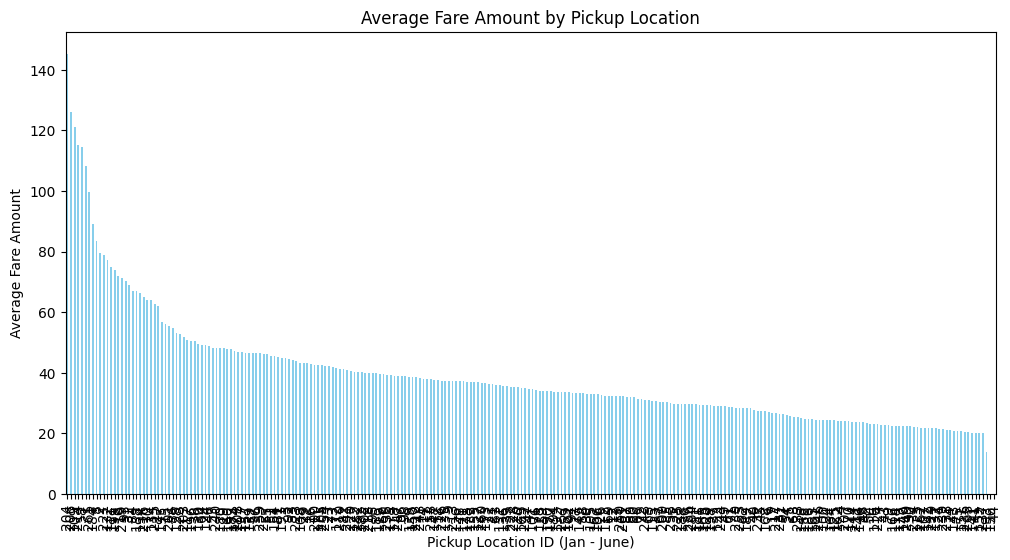

In [11]:
# avg cost per location
avg_fare_by_location = combined_updated_copy.groupby('0_PULocationID')['0_total_amount'].mean().sort_values(ascending=False)

# plotting
plt.figure(figsize=(12, 6))
avg_fare_by_location.plot(kind='bar', color='skyblue')
plt.xlabel('Pickup Location ID (Jan - June)')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by Pickup Location')
plt.xticks(rotation=90)
plt.show()


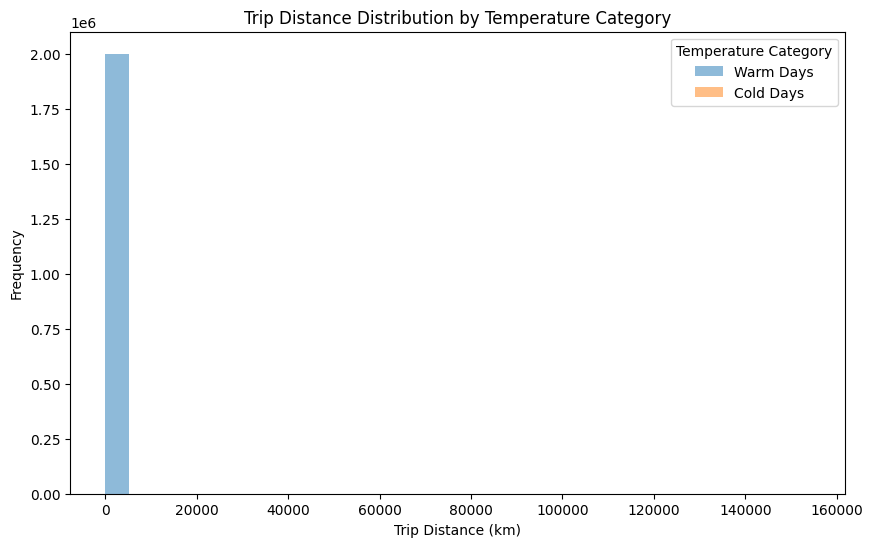

In [12]:
# temperature categories
combined_updated_copy['temp_category'] = pd.cut(
    combined_updated_copy['temperature'], 
    bins=[-10, 5, 15, 40], 
    labels=['Cold', 'Mild', 'Warm']
)

# histogram
plt.figure(figsize=(10, 6))
for temp_cat in combined_updated_copy['temp_category'].unique():
    subset = combined_updated_copy[combined_updated_copy['temp_category'] == temp_cat]
    plt.hist(subset['0_trip_distance'], bins=30, alpha=0.5, label=f'{temp_cat} Days')

plt.xlabel('Trip Distance (km)')
plt.ylabel('Frequency')
plt.title('Trip Distance Distribution by Temperature Category')
plt.legend(title='Temperature Category')
plt.show()


In [13]:
import pandas as pd


taxi_zones = pd.read_csv('taxi_zones.csv')

location_to_borough = taxi_zones.set_index('LocationID')['borough'].to_dict()


def get_borough(location_id, mapping):
    return mapping.get(location_id, 'Unknown')  

pickup_boroughs = []
dropoff_boroughs = []

# for each row in the df map the correct bourrough 
for _, row in combined_updated_copy.iterrows():
    pickup_borough = get_borough(row['0_PULocationID'], location_to_borough)
    dropoff_borough = get_borough(row['0_DOLocationID'], location_to_borough)
    pickup_boroughs.append(pickup_borough)
    dropoff_boroughs.append(dropoff_borough)

combined_updated_copy['pickup_borough'] = pickup_boroughs
combined_updated_copy['dropoff_borough'] = dropoff_boroughs
print(combined_updated_copy[['0_PULocationID', 'pickup_borough', '0_DOLocationID', 'dropoff_borough']].head())


   0_PULocationID pickup_borough  0_DOLocationID dropoff_borough
0             138         Queens             195        Brooklyn
1             138         Queens               7          Queens
2             166      Manhattan              41       Manhattan
3             148      Manhattan             114       Manhattan
4             148      Manhattan             249       Manhattan


# First ML model - how does location affect fare price?

In [14]:
import pandas as pd
import numpy as np

# # need to calculate tip percentage
combined_updated_copy['0_tip_percentage'] = (combined_updated_copy['0_tip_amount'] / combined_updated_copy['0_total_amount']) * 100

# # categories for every combination of burrough 
combined_updated_copy['location_combination'] = combined_updated_copy['pickup_borough'] + '_to_' + combined_updated_copy['dropoff_borough']
location_combination_features = pd.get_dummies(combined_updated_copy['location_combination'], drop_first=True)
# weather_features = combined_updated[['temperature', 'precipitation', 'humidity', 'wind_speed']]
other_features = combined_updated_copy[['0_trip_distance', '0_total_amount']]

#  define X and y 

# Combine All Features
X = pd.concat([location_combination_features], axis=1)

for column in X.columns:
    updated_column = [] 
    for value in X[column]:  
        if value is True:  
            updated_column.append(1)
        elif value is False:  
            updated_column.append(0)
        else:  
            updated_column.append(value)
    X[column] = updated_column

y = combined_updated_copy['0_fare_amount']

In [15]:
# preforming linear regression
def add_bias_column(X):
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
    else:
        raise ValueError("Input array must be either 1-d or 2-d")
    return Xnew

def line_of_best_fit(X, y, lambda_reg=1e-5):
    X = add_bias_column(X)
    XtX = np.matmul(X.T, X)
    
    # Add small lambda value to diagonal (regularization)
    XtX += np.eye(XtX.shape[0]) * lambda_reg
    
    XtXinv = np.linalg.inv(XtX)
    m = np.matmul(XtXinv, np.matmul(X.T, y))
    
    return m

def linreg_predict(Xnew, ynew, m):
    Xnew_with_bias = np.column_stack([np.ones(Xnew.shape[0]), Xnew])
    ypreds = np.dot(Xnew_with_bias, m)
    resids = ynew - ypreds
    mse = np.mean(resids ** 2)
    total_variance = np.sum((ynew - np.mean(ynew)) ** 2)
    explained_variance = np.sum((ypreds - np.mean(ynew)) ** 2)
    r2 = explained_variance / total_variance
    return {
        'ypreds': ypreds,
        'resids': resids,
        'mse': mse,
        'r2': r2
    }

m = line_of_best_fit(X, y)
results = linreg_predict(X, y, m)

# lowk awful so bad lol 
print(f"Mean Squared Error (MSE): {results['mse']}")
print(f"R-square: {results['r2']}")

Mean Squared Error (MSE): 266.0590382877328
R-square: 0.41773555447688493


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

rf_model = RandomForestRegressor(random_state=3, n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression:")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared: {r2_rf}")


feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("\nRandom Forest Feature Importances:")
print(feature_importances.sort_values(ascending=False))

Random Forest Regression:
Mean Squared Error (MSE): 182.5774944994615
R-squared: 0.5093106475383622

Random Forest Feature Importances:
Manhattan_to_Manhattan            0.805669
Queens_to_Unknown                 0.048119
Queens_to_Manhattan               0.042658
Manhattan_to_EWR                  0.033918
Queens_to_Brooklyn                0.023477
Manhattan_to_Queens               0.018976
Queens_to_EWR                     0.007440
Queens_to_Bronx                   0.005698
Brooklyn_to_Brooklyn              0.003323
EWR_to_EWR                        0.002737
Queens_to_Staten Island           0.002322
Unknown_to_Manhattan              0.001051
Manhattan_to_Staten Island        0.000712
Manhattan_to_Unknown              0.000549
Brooklyn_to_Bronx                 0.000544
Bronx_to_Brooklyn                 0.000544
Manhattan_to_Brooklyn             0.000535
Queens_to_Queens                  0.000409
Unknown_to_EWR                    0.000389
Brooklyn_to_Unknown               0.000354
Bron

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error


mean_fare = y_train.mean()


naive_predictions = np.full_like(y_test, fill_value=mean_fare)


naive_mse = mean_squared_error(y_test, naive_predictions)
naive_rmse = np.sqrt(naive_mse)




naive_predictions = np.full_like(y_test, fill_value=mean_fare)


ss_res = np.sum((y_test - naive_predictions) ** 2)
ss_tot = np.sum((y_test - y_test.mean()) ** 2)

naive_r2 = 1 - (ss_res / ss_tot)

print(f"Naive Model R²: {naive_r2:.4f}")
print(f"Naive Model - Mean Fare Prediction: ${mean_fare:.2f}")
print(f"Naive Model - Mean Squared Error (MSE): {naive_mse:.2f}")
print(f"Naive Model - Root Mean Squared Error (RMSE): {naive_rmse:.2f}")


Naive Model R²: -0.0000
Naive Model - Mean Fare Prediction: $19.10
Naive Model - Mean Squared Error (MSE): 372.09
Naive Model - Root Mean Squared Error (RMSE): 19.29


Random Forest Regression:
Mean Squared Error (MSE): 157.2516385773328
R-squared (R²): 0.731264678374751

Feature Importances:
norm_trip_distance                4.480018e-01
is_airport_trip                   1.815028e-01
Manhattan_to_Manhattan            1.522238e-01
Queens_to_Manhattan               8.073126e-02
Manhattan_to_Queens               2.284660e-02
Queens_to_Unknown                 2.103540e-02
Manhattan_to_EWR                  1.801611e-02
Queens_to_Queens                  1.392263e-02
Queens_to_Brooklyn                9.675979e-03
night                             8.658909e-03
wind_speed                        6.852938e-03
temperature                       5.723373e-03
Manhattan_to_Unknown              5.275582e-03
Manhattan_to_Brooklyn             4.989753e-03
humidity                          4.202691e-03
Queens_to_EWR                     2.302662e-03
Brooklyn_to_Brooklyn              2.013881e-03
precipitation                     1.871934e-03
morning                     

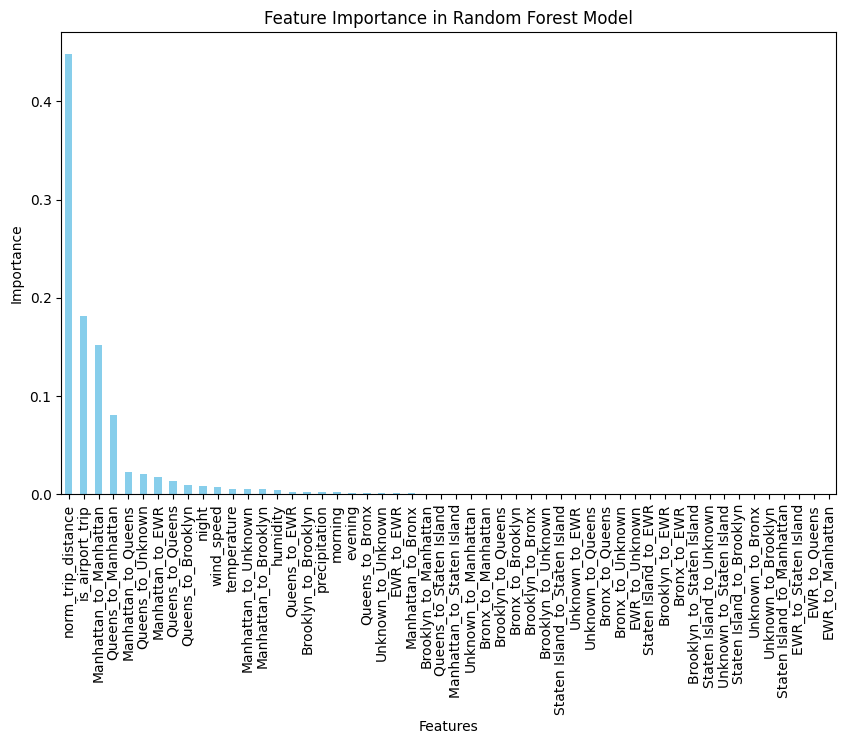

In [18]:
# making random forest more complete 

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


df = combined_updated_copy.copy()

# fixing features

# adding time of day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['0_tpep_pickup_datetime'].dt.hour.apply(get_time_of_day)
time_of_day_dummies = pd.get_dummies(df['time_of_day'], drop_first=True)

# adding and normalizing trip distance
df['norm_trip_distance'] = (df['0_trip_distance'] - df['0_trip_distance'].mean()) / df['0_trip_distance'].std()

# adding wether it is an airport trip or not
airport_locations = [1, 132, 138]  
df['is_airport_trip'] = (
    df['0_PULocationID'].isin(airport_locations) |
    df['0_DOLocationID'].isin(airport_locations)
).astype(int)

# weather features
weather_features = df[['temperature', 'precipitation', 'humidity', 'wind_speed']].fillna(0)

# Normalize weather features
scaler = StandardScaler()
normalized_weather_features = pd.DataFrame(
    scaler.fit_transform(weather_features),
    columns=weather_features.columns
)

# Combine all features
X = pd.concat([
    df[['norm_trip_distance', 'is_airport_trip']],
    time_of_day_dummies,
    normalized_weather_features,
    location_combination_features
], axis=1)

# Target variable
y = df['0_total_amount']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor(
    n_estimators=500,      # Number of trees
    max_features='sqrt',
    max_depth=15,          # Limit tree depth
    random_state=3
)


rf_model.fit(X_train, y_train)

# evaluation
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest Regression:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

# feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance in Random Forest Model")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()


Classification Report:
0.7717187582282943
157.2516385773328

Feature Importances:
norm_trip_distance    0.450610
0_total_amount        0.376363
0_tip_amount          0.155668
night                 0.003519
temperature           0.003372
wind_speed            0.003096
humidity              0.002873
precipitation         0.001520
evening               0.001504
morning               0.001476
dtype: float64


<Axes: >

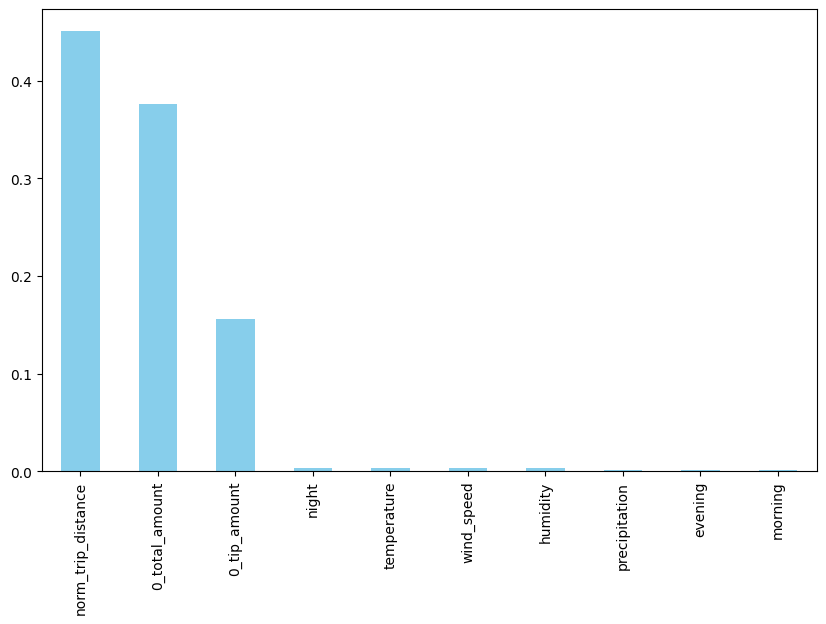

In [19]:
# Use the is_airport_trip column as the target
y_encoded = df['is_airport_trip']
X = pd.concat([
    df[['norm_trip_distance', '0_tip_amount', '0_total_amount']],
    time_of_day_dummies,
    normalized_weather_features
], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Fit the Random Forest model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Classification Report:")
r2 = r2_score(y_test, y_pred)
print(r2)
print(mse)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(feature_importances)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')

#### A discussion of the preliminary results:
1. Mean Squared Error (MSE) = 266.06
   - Given NYC taxi fares typically range from $10-$50, an MSE of 266 means the average prediction error is around $16
   - This suggests the model needs large improvement

2. R-squared = 0.4177 (41.77%)
   - This means the model explains about 42% of the variance in fare amounts
   - In other words, location combinations alone account for less than half of fare variability
   - This is suggesting that:
      - Other important variables are missing (like distance, time of day)
      - The relationship might be non-linear
      - Location alone is insufficient for accurate fare prediction

3. Some comments towards our question to investigate: 
   - The fare prices could be not highly related to the location, which didn't match our assumption. 
   - Our following model will select more relevant data for training, as long as using a better model (poly-regression, or neural network) for training purposes. 
   - We need to investigate through the dataset, and find some data that are highly-related for training, in order to find patterns between each column of the dataset and come up with better result and conclusion for our investigations. 
